# <font color=blue>Import necessary libraries</font>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix,accuracy_score, fbeta_score

# Import Tensorflow
import tensorflow as tf
from tensorflow import keras

#Import Keras API
from keras.models import Sequential, load_model       
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import adam
from keras.callbacks import History, Callback,EarlyStopping, ModelCheckpoint
from keras.regularizers import l1
from keras import regularizers

Using TensorFlow backend.


# <font color=blue>Data Preparation</font>

## Import Dataset and check distribution

In [2]:
df = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/creditcard-training set v2.csv')
df = df.rename(columns={ df.columns[2]: "Fraud" })

#check the distribution
# for row in df.head():
#     fig=plt.figure(figsize=(17,10))
#     df.hist(column=row)
#     plt.xlabel(row,fontsize=15)
#     plt.ylabel("Frequency",fontsize=15)

## Drop null records and unwanted features

In [3]:
# drop rows which has null values
df = df.dropna()

#drop feature 23 since it is meaningless in our analysis
df = df.drop(['Feature 23'], axis=1)

## Split features and class into variables & standardize features

In [4]:
# Splitting our X and Y variables
Y = df.Fraud
Y = Y.values.reshape(Y.shape[0],1)

df = df.drop('Fraud', 1)
X = df.values

#Normalize our data
sc = StandardScaler()
X = sc.fit_transform(X)

## Split into training and testing set, oversampling of the minority class

In [5]:
def Oversample(X_train,Y_train,print_output=False):
    
    #Convert back to dataframe for random oversampling
    Train_set = np.concatenate((X_train, Y_train), axis=1)
    df = pd.DataFrame.from_records(Train_set)

    # Class count
    count_class_0, count_class_1 = df.iloc[:,30].value_counts()

    # Divide by class
    df_class_0 = df[df.iloc[:,30] == 0]
    df_class_1 = df[df.iloc[:,30] == 1]
    
    #Oversample the minority class and joining it back to original dataframe
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    df = pd.concat([df_class_0, df_class_1_over], axis=0)

    #Shuffle rows
    df.sample(frac=1)
    
    #Splitting data back into X and Y variables
    Y_train = df.iloc[:,30].values
    X_train = df.iloc[:,0:30].values
    
    if print_output == True:
        
        #Print number of rows by class
        print('Random over-sampling:')
        print(df.iloc[:,30].value_counts())
    
    return X_train, Y_train

#Split data into train and test set (80 to 20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Oversampling of our training set
X_train, Y_train = Oversample(X_train,Y_train)

# <font color=blue>Building and Training the Model </font>

## Defining the Neural Network Using Keras API

In [6]:
#Create a NN with 3 hidden layers using relu activation functions. 
#Output layer will use sigmoid function
model = Sequential()
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(512,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# Compile the model with appropriate Loss function
model.compile(optimizer = adam(), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

## Defining functions before training the model

In [8]:
#Converts the model's output from probability into classes 1 or 0
def Convert_prob_to_class(Y_test_hat):
    
    Y_test_hat[Y_test_hat > 0.5] = 1
    Y_test_hat[Y_test_hat < 0.5] = 0

#Plot the ROC graph
def PlotROC(y_test,pred):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return roc_auc

#Plot the loss history graph
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
#Printing the metrics and graphs of the model
def PrintStats(y_test, pred, history= None, output_print=False):
    
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    precscore = round(precision_score(y_test, pred), 2)
    accScore = round(accuracy_score(y_test, pred), 2)
    beta = 4
    fbetaScore = round((1+beta) * (precscore * recallScore) / ((beta * precscore) + recallScore),2)
    
    #plot loss curve
    if history is not None:
        plot_history(history)
    
    #roc curve
    auc = PlotROC(y_test,pred)
    
    print("Accuracy for Model : {acc_score}".format(acc_score = accScore))
    print("Precision for Model : {prec_score}".format(prec_score = precscore))
    print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))
    print("F-Beta Score for Model : {fbeta_score}".format(fbeta_score = fbetaScore))
    
    output = [accScore,precscore,recallScore,f1Score, fbetaScore,auc]
    
    if output_print:
        return output

## Training the model (Alternatively, jump to loading of trained model)

In [9]:
#Train model
epochs = 50
batch_size = 72

callbacks = [EarlyStopping(monitor='val_loss', patience=7),
             ModelCheckpoint(filepath='saved_model_trained.hdf5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, Y_train, 
                    validation_data = (X_test,Y_test), 
                    epochs = epochs,
                    batch_size = batch_size,
                   callbacks = callbacks)

Train on 363760 samples, validate on 45553 samples
Epoch 1/50
363760/363760 [==============================] - 169s 465us/step - loss: 0.0161 - acc: 0.9956 - val_loss: 0.0652 - val_acc: 0.9881
Epoch 2/50
363760/363760 [==============================] - 169s 465us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0094 - val_acc: 0.9990
Epoch 3/50
363760/363760 [==============================] - 168s 462us/step - loss: 0.0072 - acc: 0.9991 - val_loss: 0.0101 - val_acc: 0.9987
Epoch 4/50
363760/363760 [==============================] - 166s 457us/step - loss: 0.0062 - acc: 0.9991 - val_loss: 0.0103 - val_acc: 0.9988
Epoch 5/50
363760/363760 [==============================] - 174s 477us/step - loss: 0.0128 - acc: 0.9989 - val_loss: 0.0093 - val_acc: 0.9992
Epoch 6/50
363760/363760 [==============================] - 166s 457us/step - loss: 0.0139 - acc: 0.9988 - val_loss: 0.0113 - val_acc: 0.9991
Epoch 7/50
363760/363760 [==============================] - 169s 464us/step - loss: 0.0235 - acc:

## Testing the data on the trained model

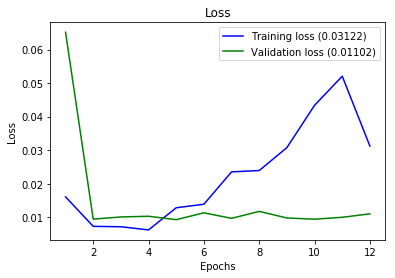

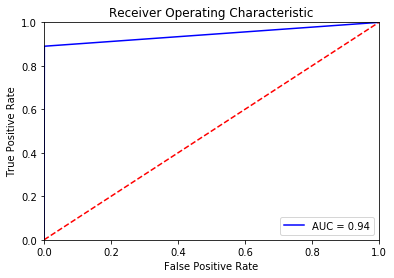

Accuracy for Model : 1.0
Precision for Model : 0.65
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.75
F-Beta Score for Model : 0.83


In [10]:
#Run forward prop to get predicted values
Y_test_hat = model.predict(X_test)
Convert_prob_to_class(Y_test_hat)

#If model is loaded from file, we will not have any history logs
try:
    history
except NameError:
    history = None

#Print metrics and graphs
PrintStats(Y_test,Y_test_hat,history)

# <font color=blue>Cross Validating the Model </font>

## K-fold Cross Validation

Epoch 1/5
409308/409308 [==============================] - 186s 454us/step - loss: 0.1354 - acc: 0.9914
Epoch 2/5
409308/409308 [==============================] - 186s 453us/step - loss: 0.1453 - acc: 0.9908
Epoch 3/5
409308/409308 [==============================] - 185s 453us/step - loss: 0.1741 - acc: 0.9891
Epoch 4/5
409308/409308 [==============================] - 188s 459us/step - loss: 0.1917 - acc: 0.9880
Epoch 5/5
409308/409308 [==============================] - 187s 457us/step - loss: 0.2029 - acc: 0.9873

Metrics for fold number: 1


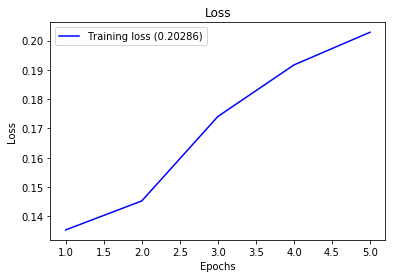

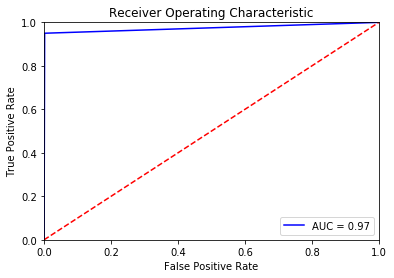

Accuracy for Model : 1.0
Precision for Model : 0.67
Sensitivity/Recall for Model : 0.95
F1 Score for Model : 0.78
F-Beta Score for Model : 0.88
Epoch 1/5
409260/409260 [==============================] - 185s 453us/step - loss: 0.1914 - acc: 0.9880
Epoch 2/5
409260/409260 [==============================] - 185s 452us/step - loss: 0.1856 - acc: 0.9884
Epoch 3/5
409260/409260 [==============================] - 185s 451us/step - loss: 0.2000 - acc: 0.9875
Epoch 4/5
409260/409260 [==============================] - 187s 457us/step - loss: 0.2233 - acc: 0.9860
Epoch 5/5
409260/409260 [==============================] - 186s 455us/step - loss: 0.2410 - acc: 0.9850

Metrics for fold number: 2


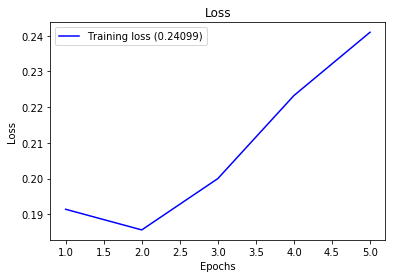

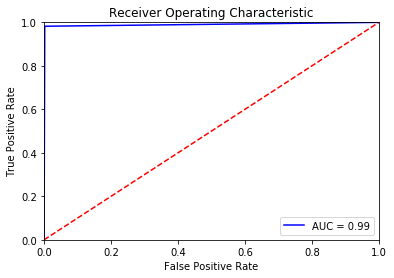

Accuracy for Model : 1.0
Precision for Model : 0.54
Sensitivity/Recall for Model : 0.98
F1 Score for Model : 0.7
F-Beta Score for Model : 0.84
Epoch 1/5
409208/409208 [==============================] - 185s 453us/step - loss: 0.1756 - acc: 0.9890
Epoch 2/5
409208/409208 [==============================] - 186s 454us/step - loss: 0.1529 - acc: 0.9904
Epoch 3/5
409208/409208 [==============================] - 185s 453us/step - loss: 0.1560 - acc: 0.9903
Epoch 4/5
409208/409208 [==============================] - 184s 449us/step - loss: 0.1854 - acc: 0.9885
Epoch 5/5
409208/409208 [==============================] - 185s 453us/step - loss: 0.1836 - acc: 0.9885

Metrics for fold number: 3


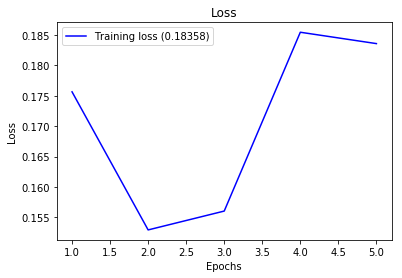

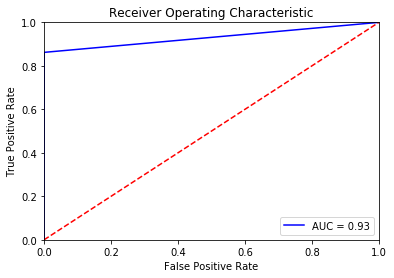

Accuracy for Model : 1.0
Precision for Model : 0.69
Sensitivity/Recall for Model : 0.86
F1 Score for Model : 0.77
F-Beta Score for Model : 0.82
Epoch 1/5
409230/409230 [==============================] - 184s 450us/step - loss: 0.1875 - acc: 0.9883
Epoch 2/5
409230/409230 [==============================] - 184s 449us/step - loss: 0.1851 - acc: 0.9885
Epoch 3/5
409230/409230 [==============================] - 186s 455us/step - loss: 0.1752 - acc: 0.9891
Epoch 4/5
409230/409230 [==============================] - 188s 458us/step - loss: 0.2437 - acc: 0.9848
Epoch 5/5
409230/409230 [==============================] - 184s 449us/step - loss: 0.1895 - acc: 0.9882

Metrics for fold number: 4


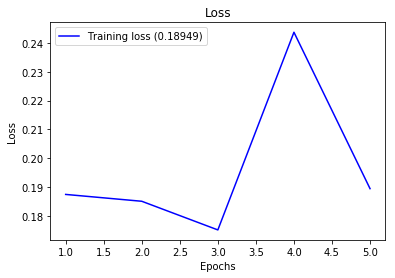

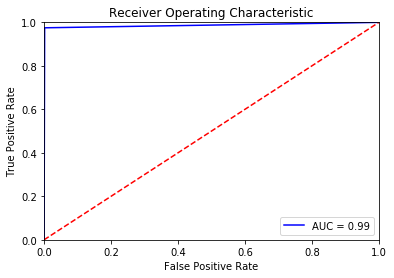

Accuracy for Model : 1.0
Precision for Model : 0.51
Sensitivity/Recall for Model : 0.98
F1 Score for Model : 0.67
F-Beta Score for Model : 0.83
Epoch 1/5
409210/409210 [==============================] - 186s 454us/step - loss: 0.2047 - acc: 0.9872
Epoch 2/5
409210/409210 [==============================] - 185s 453us/step - loss: 0.1993 - acc: 0.9876
Epoch 3/5
409210/409210 [==============================] - 186s 455us/step - loss: 0.2125 - acc: 0.9868
Epoch 4/5
409210/409210 [==============================] - 185s 452us/step - loss: 0.2236 - acc: 0.9861
Epoch 5/5
409210/409210 [==============================] - 185s 453us/step - loss: 0.2370 - acc: 0.9852

Metrics for fold number: 5


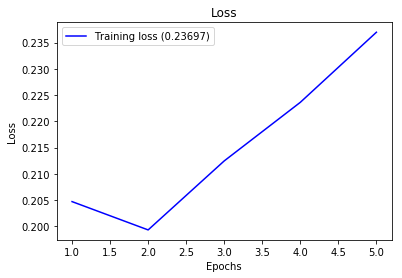

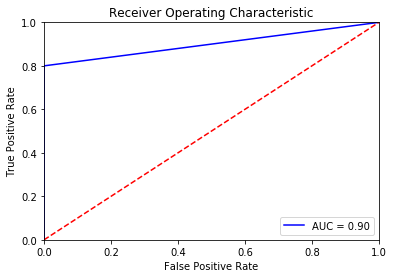

Accuracy for Model : 1.0
Precision for Model : 1.0
Sensitivity/Recall for Model : 0.8
F1 Score for Model : 0.89
F-Beta Score for Model : 0.83
Epoch 1/5
409194/409194 [==============================] - 185s 452us/step - loss: 0.2173 - acc: 0.9864
Epoch 2/5
409194/409194 [==============================] - 185s 451us/step - loss: 0.2216 - acc: 0.9862s - loss: 0.2217 - acc: 0
Epoch 3/5
409194/409194 [==============================] - 184s 451us/step - loss: 0.2121 - acc: 0.9868
Epoch 4/5
409194/409194 [==============================] - 183s 446us/step - loss: 0.1795 - acc: 0.9888
Epoch 5/5
409194/409194 [==============================] - 185s 453us/step - loss: 0.1643 - acc: 0.9897

Metrics for fold number: 6


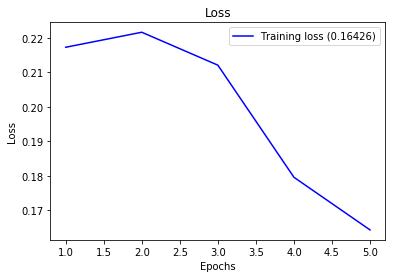

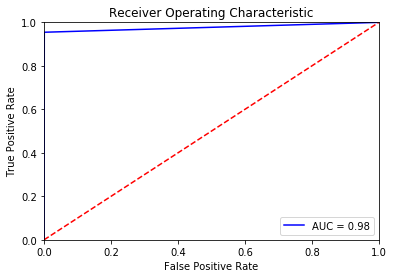

Accuracy for Model : 1.0
Precision for Model : 0.58
Sensitivity/Recall for Model : 0.95
F1 Score for Model : 0.72
F-Beta Score for Model : 0.84
Epoch 1/5
409336/409336 [==============================] - 185s 452us/step - loss: 0.1706 - acc: 0.9893
Epoch 2/5
409336/409336 [==============================] - 184s 449us/step - loss: 0.1760 - acc: 0.9890
Epoch 3/5
409336/409336 [==============================] - 185s 451us/step - loss: 0.1715 - acc: 0.9893
Epoch 4/5
409336/409336 [==============================] - 183s 448us/step - loss: 0.1905 - acc: 0.9881
Epoch 5/5
409336/409336 [==============================] - 184s 450us/step - loss: 0.1723 - acc: 0.9893

Metrics for fold number: 7


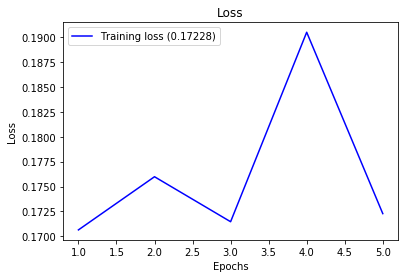

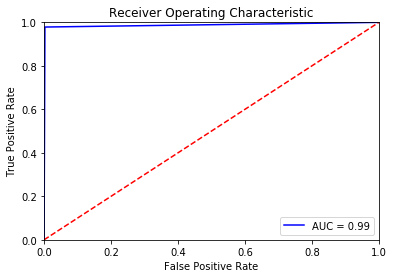

Accuracy for Model : 1.0
Precision for Model : 0.61
Sensitivity/Recall for Model : 0.98
F1 Score for Model : 0.76
F-Beta Score for Model : 0.87
Epoch 1/5
409168/409168 [==============================] - 186s 454us/step - loss: 0.1684 - acc: 0.9895
Epoch 2/5
409168/409168 [==============================] - 183s 448us/step - loss: 0.1726 - acc: 0.9892
Epoch 3/5
409168/409168 [==============================] - 185s 453us/step - loss: 0.1732 - acc: 0.9892
Epoch 4/5
409168/409168 [==============================] - 185s 453us/step - loss: 0.1463 - acc: 0.9909
Epoch 5/5
409168/409168 [==============================] - 185s 451us/step - loss: 0.1547 - acc: 0.9903

Metrics for fold number: 8


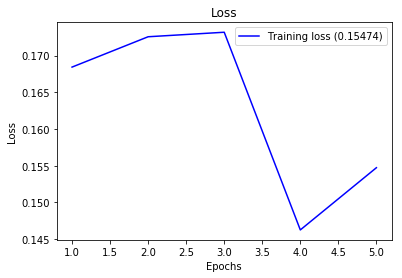

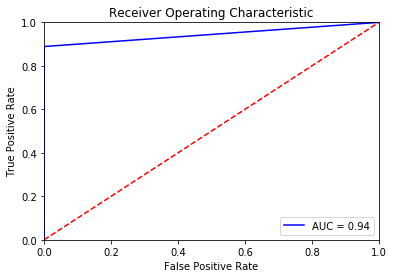

Accuracy for Model : 1.0
Precision for Model : 0.42
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.57
F-Beta Score for Model : 0.73
Epoch 1/5
409206/409206 [==============================] - 185s 451us/step - loss: 0.1743 - acc: 0.9892
Epoch 2/5
409206/409206 [==============================] - 185s 452us/step - loss: 0.1952 - acc: 0.9878
Epoch 3/5
409206/409206 [==============================] - 184s 450us/step - loss: 0.1970 - acc: 0.9877
Epoch 4/5
409206/409206 [==============================] - 186s 455us/step - loss: 0.2319 - acc: 0.9856
Epoch 5/5
409206/409206 [==============================] - 185s 451us/step - loss: 0.1761 - acc: 0.9890

Metrics for fold number: 9


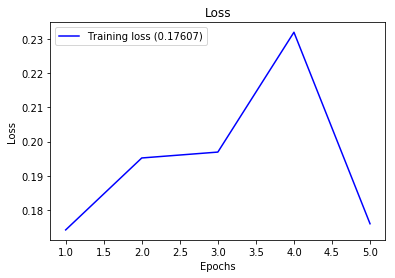

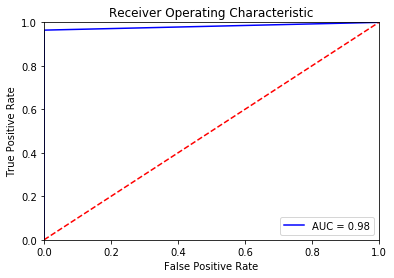

Accuracy for Model : 1.0
Precision for Model : 0.77
Sensitivity/Recall for Model : 0.96
F1 Score for Model : 0.86
F-Beta Score for Model : 0.91
Epoch 1/5
409198/409198 [==============================] - 184s 450us/step - loss: 0.1460 - acc: 0.9909
Epoch 2/5
409198/409198 [==============================] - 185s 452us/step - loss: 0.1868 - acc: 0.9884
Epoch 3/5
409198/409198 [==============================] - 186s 455us/step - loss: 0.2042 - acc: 0.9873
Epoch 4/5
409198/409198 [==============================] - 186s 455us/step - loss: 0.2025 - acc: 0.9874
Epoch 5/5
409198/409198 [==============================] - 186s 455us/step - loss: 0.1879 - acc: 0.9883

Metrics for fold number: 10


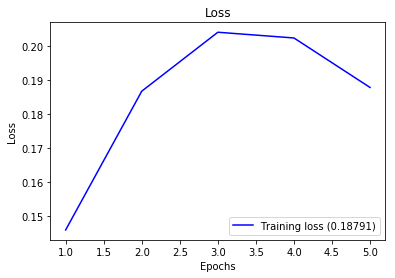

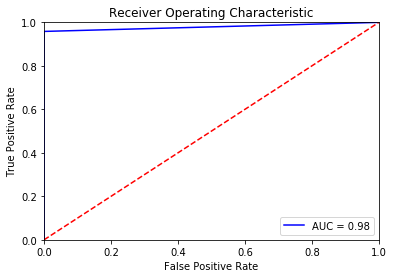

Accuracy for Model : 1.0
Precision for Model : 0.92
Sensitivity/Recall for Model : 0.96
F1 Score for Model : 0.94
F-Beta Score for Model : 0.95

Summary metrics:
Accuracy for Model : 1.0
Precision for Model : 0.67
Sensitivity/Recall for Model : 0.93
F1 Score for Model : 0.77
F-Beta Score for Model : 0.85
AUC for Model : 0.9651905625560848


In [11]:
#Define parameters for k-fold cross val
n_folds = 10
kf = KFold(n_folds)
Metric_array = np.zeros(6)

epochs = 5
batch_size = 72
counter = 1

#Start k-fold cross validation 
for train_index, test_index in kf.split(X):
    
    #Split into training and testing set
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    #Oversampling of training set ONLY
    X_train, Y_train = Oversample(X_train,Y_train)
    
    #run the model
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)
    
    #Run forward prop to get predicted values
    Y_test_hat = model.predict(X_test)
    Convert_prob_to_class(Y_test_hat)
    
    print('\nMetrics for fold number: ' + str(counter))
    counter += 1
    
    #Print metrics and store in numpy array to average after end of cv 
    Metric_array += PrintStats(Y_test,Y_test_hat,history,True)
    
#Averaging of metrics across folds    
Metric_array /= n_folds

print('\nSummary metrics:')
print("Accuracy for Model : {acc_score}".format(acc_score = np.around(Metric_array[0],decimals = 2)))
print("Precision for Model : {prec_score}".format(prec_score = np.around(Metric_array[1],decimals = 2)))
print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = np.around(Metric_array[2],decimals = 2)))
print("F1 Score for Model : {f1_score}".format(f1_score = np.around(Metric_array[3],decimals = 2)))
print("F-Beta Score for Model : {f1_score}".format(f1_score = np.around(Metric_array[4],decimals = 2)))
print("AUC for Model : {auc}".format(auc = Metric_array[5]))